# Identify SS using PARSIM-K


In [193]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import joblib

from __future__ import division

from past.utils import old_div

# Checking path to access other files
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *
from sippy import functionsetSIM as fsetSIM

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a Dataset

In [194]:
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

In [195]:
constrains = np.array([[0, 0.5], [0, 1]])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constrains)

In [196]:
Ts = 1
h1 = 1
h2 = 0.5
u1 = steps[0,:]
u2 = steps[1,:]

sim = TwoTanks.simulate([h1, h2], steps, Ts)

In [197]:
# add noise to sim data
add_noise = True
if add_noise:
    # add noise to the simulation data
    # set random seed for reproducibility
    np.random.seed(42)
    noise = np.random.normal(0, 0.02, sim["Y"].shape)
    sim["Y"] += noise

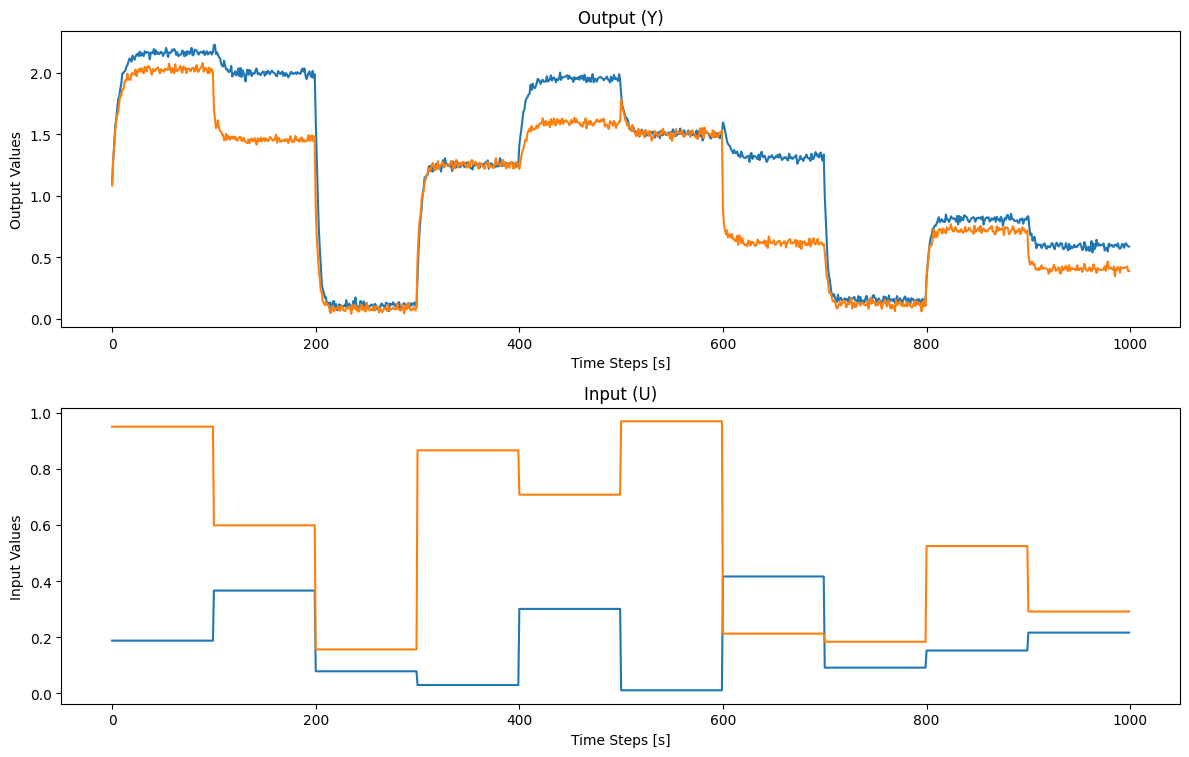

In [198]:
part = 1000

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(sim["Y"][:part])
plt.title("Output (Y)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Output Values")

plt.subplot(2, 1, 2)
plt.plot(sim["U"][:part])
plt.title("Input (U)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Values")

plt.tight_layout(rect=[0, 0, 1, 0.96])

In [199]:
# Load the scalers
scaler = joblib.load('../data/scaler.pkl')
scalerU = joblib.load('../data/scalerU.pkl')

# Scale the data
sim["Y"] = scaler.transform(sim["Y"])
sim["U"] = scalerU.transform(sim["U"])

In [200]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

## Identification using PARSIM-K
```python

In [201]:
y_tot = train_sim["Y"].copy()
U = train_sim["U"].T.copy()

In [202]:
sys_id = system_identification(y_tot.copy(), U.copy(), 'PARSIM-K', SS_fixed_order = 3)
#sys_id = system_identification(y_tot, U, method, SS_fixed_order = 2 )

In [203]:
sys_id.A

array([[ 0.83531813,  0.16007989,  0.12709007],
       [ 0.06902407,  0.91392562, -0.06225068],
       [ 0.06334987, -0.04640546,  0.94701724]])

In [204]:
append = "_parsimK"
np.save('../data/A' + append + '.npy', sys_id.A)
np.save('../data/B' + append + '.npy', sys_id.B)
np.save('../data/C' + append + '.npy', sys_id.C)

In [205]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, test_sim["U"].T, np.linalg.pinv(sys_id.C)@test_sim["Y"][0].reshape(-1, 1)
    )

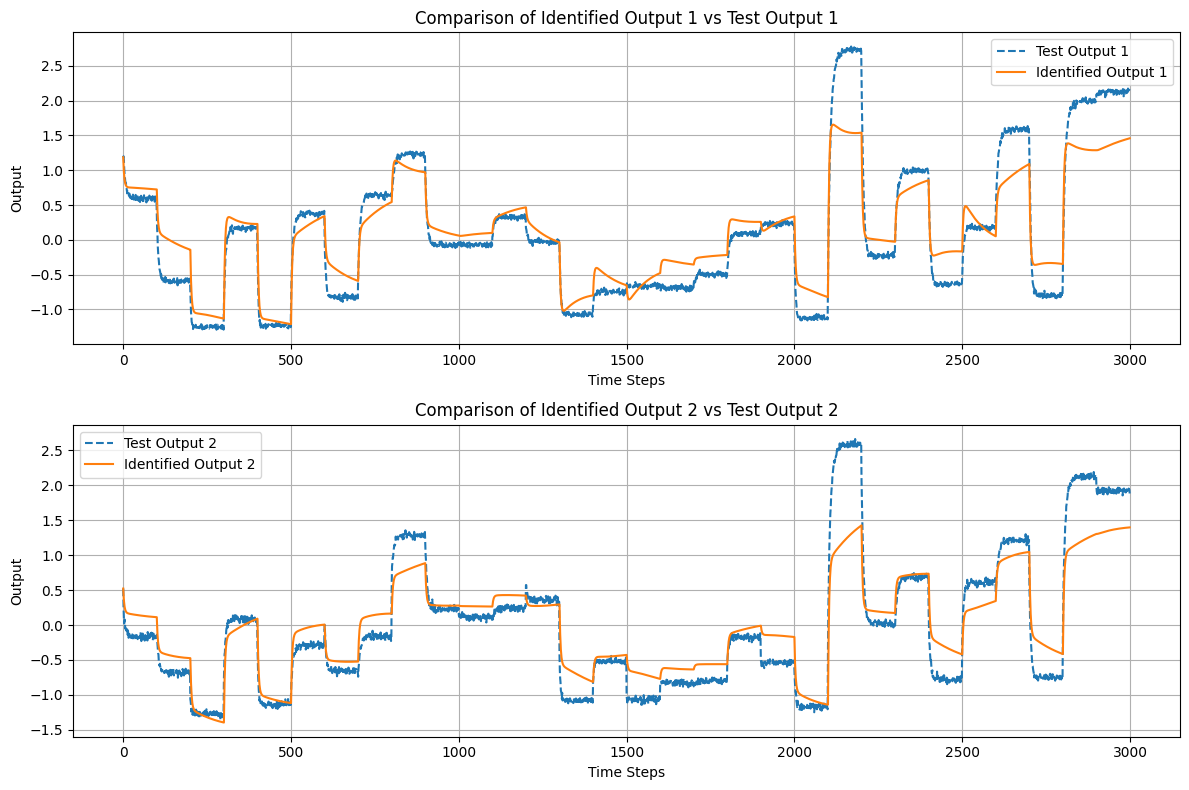

In [206]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(test_sim["Y"][:, 0], label="Test Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Test Output 1")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(test_sim["Y"][:, 1], label="Test Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Test Output 2")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [207]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, train_sim["U"].T, np.linalg.pinv(sys_id.C)@train_sim["Y"][0].reshape(-1, 1)#sys_id.x0
    )

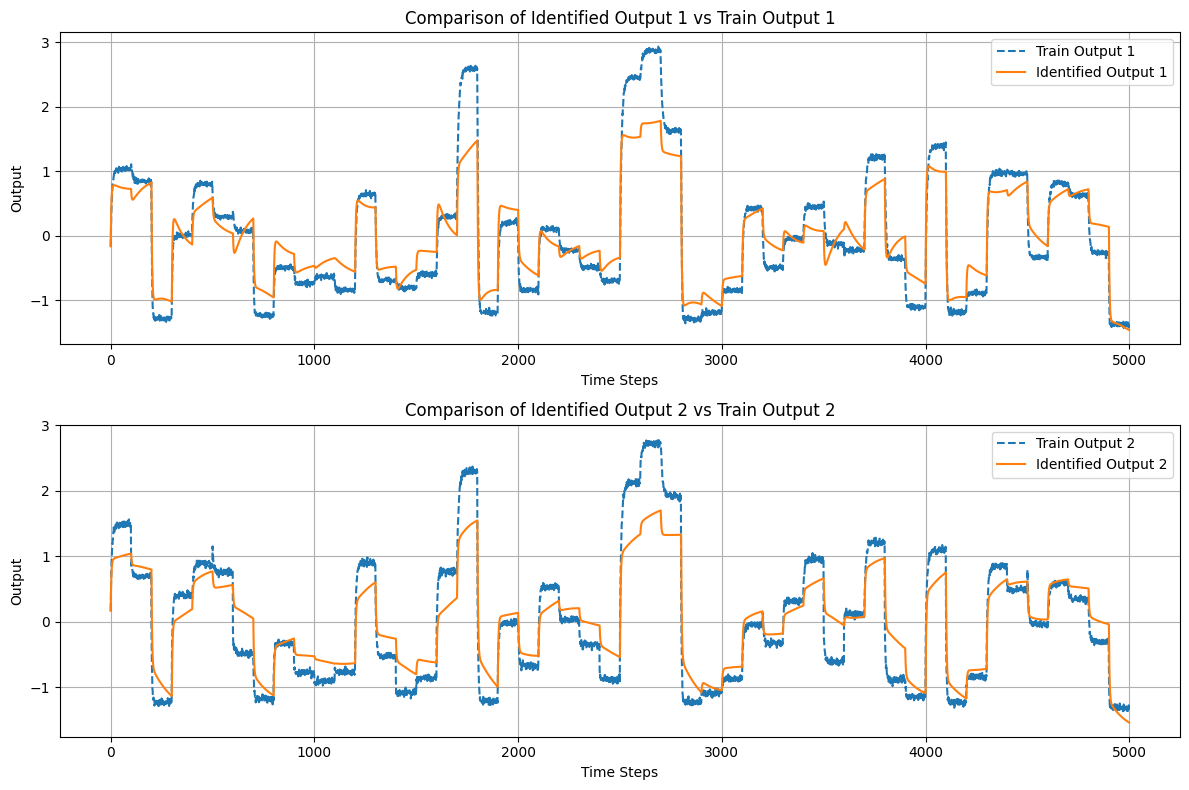

In [208]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train_sim["Y"][:, 0], label="Train Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Train Output 1")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(train_sim["Y"][:, 1], label="Train Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Train Output 2")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()